In [1]:
!nvidia-smi

Wed Apr  3 00:36:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX150           On  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8              N/A / ERR! |      4MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch

torch.cuda.get_device_name(0)

'NVIDIA GeForce MX150'

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.get_num_threads()

4

In [5]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as data

In [6]:
# LSTM

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [7]:
# GRU

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.gru = nn.GRU(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.linear(x)
        return x

In [8]:
# RNN

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.rnn = nn.RNN(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

In [9]:
from torch.utils.data import Dataset

class FunctionDataset:
    class SequenceDs(Dataset):
        def __init__(self, X, y) -> None:
            super().__init__()
            self.X = X
            self.y = y

        def __len__(self):
            return len(self.y)

        def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
            return torch.tensor(self.X[index]).float(), torch.tensor(self.y[index]).float()

    def __init__(self, y_f, lookback, split_ratio=0.7):

        self.y_f = y_f
        self.total_samples = len(y_f)
        self.lookback = lookback

        X, y = self.generate_sequence(self.y_f, self.lookback)


        # split into train, validation and test set
        self.X = X[:int((self.total_samples - lookback) * split_ratio)]
        self.X_test = X[int((self.total_samples - lookback) *split_ratio):]

        self.y = y[:int((self.total_samples - lookback) * split_ratio)]
        self.y_test = y[int((self.total_samples - lookback) * split_ratio):]

        print(f'[Dataset]: total samples {self.total_samples}, sequence length {self.lookback}, total sequences {len(X)}, split ratio {split_ratio}, train {len(self.X)}, test {len(self.X_test)}')

    def generate_sequence(self, y, l):
        X_seq = []
        y_seq = []
        for i in range(len(y) - l):
            X_seq.append(y[i:i+l])
            y_seq.append(y[i+1:i+l+1])
        return np.array(X_seq), np.array(y_seq)

    def get_train_ds(self):
        return self.SequenceDs(self.X, self.y)

    def get_test_ds(self):
        return self.SequenceDs(self.X_test, self.y_test)

In [10]:
import time

def train(net, trainloader, testloader, criterion, optimizer, epochs, points_to_print=20):
    learning_start = time.time()

    net.train()

    print_every_n_batches = max(1, round(epochs * len(trainloader) / points_to_print))
    print('Print every %d batches' % print_every_n_batches)

    for epoch in range(epochs):
        # train
        for i, data in enumerate(trainloader, 0):
            net.train()

            X, y = data

            if len(X.shape) == 2:
                X = X.unsqueeze(2)
                y = y.unsqueeze(2)

            X = X.cuda()
            y = y.cuda()

            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(X)
            loss = criterion(outputs, y)
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), 3)
            optimizer.step()


            if (epoch * len(trainloader) + (i + 1)) % print_every_n_batches == print_every_n_batches - 1:

                # validate
                net.eval()

                train_loss = 0.0
                val_loss = 0.0

                with torch.no_grad():
                    for _, data in enumerate(trainloader, 0):
                        X, y = data

                        if len(X.shape) == 2:
                            X = X.unsqueeze(2)
                            y = y.unsqueeze(2)

                        X = X.cuda()
                        y = y.cuda()

                        outputs = net(X)
                        loss = criterion(outputs, y)

                        train_loss += loss.item()

                    for _, data in enumerate(testloader, 0):
                        X, y = data

                        if len(X.shape) == 2:
                            X = X.unsqueeze(2)
                            y = y.unsqueeze(2)

                        X = X.cuda()
                        y = y.cuda()

                        outputs = net(X)
                        loss = criterion(outputs, y)

                        val_loss += loss.item()


                print('[%4d, %4d] train RMSE: %.6g, test RMSE: %.6g' % (epoch + 1, i + 1, np.sqrt(train_loss / len(trainloader)), np.sqrt(val_loss / len(testloader))))


    learning_end = time.time()

    return learning_end - learning_start

In [11]:
def predict(net, loader, criterion):
    net.eval()

    preds = []
    loss = 0.0

    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            X, y = data

            if len(X.shape) == 2:
                X = X.unsqueeze(2)
                y = y.unsqueeze(2)

            X = X.cuda()
            y = y.cuda()

            outputs = net(X)
            loss += criterion(outputs, y).item()

            # append joined outpus
            preds = np.concatenate((preds, outputs[:, -1, :].cpu().numpy().flatten()))

    return loss / len(loader), preds

In [12]:
def plot_model_results(title, actual, train_preds, test_preds, lookback = 4):
    train_serie = np.ones_like(actual) * np.nan
    test_serie = np.ones_like(actual) * np.nan

    train_serie[lookback:lookback + len(train_preds)] = train_preds
    test_serie[lookback + len(train_preds):] = test_preds

    plt.plot(actual, label='Actual')
    plt.plot(train_serie, label='Train predicted', color='red')
    plt.plot(test_serie, label='Test predicted', color='green')
    plt.title(title)
    plt.legend()
    plt.show()

In [13]:
def plot_all_results(title, lookback, actual, train_preds_lstm, test_preds_lstm, train_preds_gru, test_preds_gru, train_preds_rnn, test_preds_rnn):
    train_serie_lstm = np.ones_like(actual) * np.nan
    test_serie_lstm = np.ones_like(actual) * np.nan
    train_serie_lstm[lookback:lookback + len(train_preds_lstm)] = train_preds_lstm
    test_serie_lstm[lookback + len(train_preds_lstm):] = test_preds_lstm

    train_serie_gru = np.ones_like(actual) * np.nan
    test_serie_gru = np.ones_like(actual) * np.nan
    train_serie_gru[lookback:lookback + len(train_preds_gru)] = train_preds_gru
    test_serie_gru[lookback + len(train_preds_gru):] = test_preds_gru

    train_serie_rnn = np.ones_like(actual) * np.nan
    test_serie_rnn = np.ones_like(actual) * np.nan
    train_serie_rnn[lookback:lookback + len(train_preds_rnn)] = train_preds_rnn
    test_serie_rnn[lookback + len(train_preds_rnn):] = test_preds_rnn


    plt.figure(figsize=(20, 5))

    plt.subplot(1, 3, 1)
    plt.plot(actual, label='Actual')
    plt.plot(train_serie_lstm, label='Train predicted', color='red')
    plt.plot(test_serie_lstm, label='Test predicted', color='green')
    plt.title('LSTM model')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(actual, label='Actual')
    plt.plot(train_serie_gru, label='Train predicted', color='red')
    plt.plot(test_serie_gru, label='Test predicted', color='green')
    plt.title('GRU model')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(actual, label='Actual')
    plt.plot(train_serie_rnn, label='Train predicted', color='red')
    plt.plot(test_serie_rnn, label='Test predicted', color='green')
    plt.title('RNN model')
    plt.legend()

    plt.suptitle(title, fontsize=16, y=1.01)

    plt.show()

In [14]:
batch_size = 8
epochs = 2000

### Zad 1

In [15]:
# read data from ariline-passangers.csv. 
df = pd.read_csv('airline-passengers.csv')
df["Passengers"] = df["Passengers"].apply(lambda x: float(x))

df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [16]:
# print df data types
df.dtypes

Month          object
Passengers    float64
dtype: object

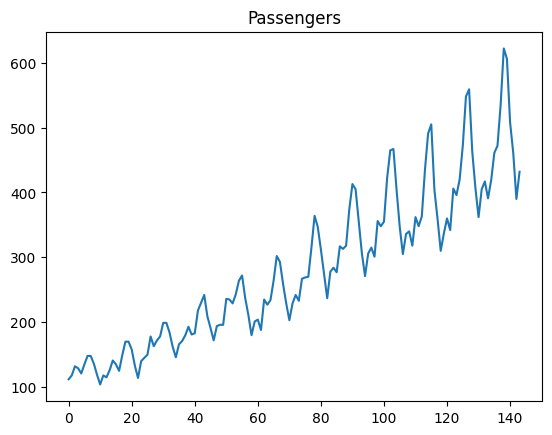

In [17]:
plt.plot(df['Passengers'])
plt.title('Passengers')
plt.show()

In [18]:
ds = FunctionDataset(df['Passengers'], lookback=4, split_ratio=0.8)

train_shuffle_loader = data.DataLoader(ds.get_train_ds(), shuffle=True, batch_size=batch_size)
train_not_shuffle_loader = data.DataLoader(ds.get_train_ds(), shuffle=False, batch_size=batch_size)
test_loader = data.DataLoader(ds.get_test_ds(), shuffle=False, batch_size=batch_size)

[Dataset]: total samples 144, sequence length 4, total sequences 140, split ratio 0.8, train 112, test 28


In [19]:
len(train_shuffle_loader), len(test_loader)

(14, 4)

In [20]:
# model z zajec
net_lstm = LSTM(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_lstm.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_lstm, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 1400 batches
[ 100,   13] train RMSE: 201.993, test RMSE: 398.91
[ 200,   13] train RMSE: 153.387, test RMSE: 343.87
[ 300,   13] train RMSE: 118.903, test RMSE: 299.981
[ 400,   13] train RMSE: 96.7691, test RMSE: 268.09
[ 500,   13] train RMSE: 83.9587, test RMSE: 247.887
[ 600,   13] train RMSE: 73.3738, test RMSE: 230.066
[ 700,   13] train RMSE: 63.5408, test RMSE: 211.613
[ 800,   13] train RMSE: 54.553, test RMSE: 193.327
[ 900,   13] train RMSE: 46.6053, test RMSE: 175.192
[1000,   13] train RMSE: 40.3342, test RMSE: 157.95
[1100,   13] train RMSE: 35.5192, test RMSE: 142.589
[1200,   13] train RMSE: 31.7854, test RMSE: 129.077
[1300,   13] train RMSE: 29.2632, test RMSE: 118.056
[1400,   13] train RMSE: 27.2179, test RMSE: 107.635
[1500,   13] train RMSE: 26.2385, test RMSE: 99.5127
[1600,   13] train RMSE: 24.8486, test RMSE: 92.463
[1700,   13] train RMSE: 24.648, test RMSE: 88.4275
[1800,   13] train RMSE: 23.941, test RMSE: 85.7195
[1900,   13] train RMSE: 22.9

In [21]:
train_predict_loss_lstm, train_preds_lstm = predict(net_lstm, train_not_shuffle_loader, criterion)
test_predict_loss_lstm, test_preds_lstm = predict(net_lstm, test_loader, criterion)

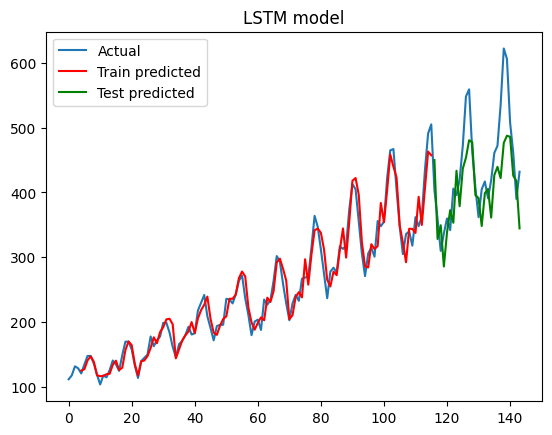

In [22]:
plot_model_results('LSTM model', df['Passengers'], train_preds_lstm, test_preds_lstm)

In [23]:
net_gru = GRU(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_gru.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_gru, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 1400 batches
[ 100,   13] train RMSE: 193.365, test RMSE: 389.328
[ 200,   13] train RMSE: 139.083, test RMSE: 326.243
[ 300,   13] train RMSE: 105.194, test RMSE: 280.606
[ 400,   13] train RMSE: 85.1872, test RMSE: 250.231
[ 500,   13] train RMSE: 71.4769, test RMSE: 227.082
[ 600,   13] train RMSE: 59.4397, test RMSE: 204.455
[ 700,   13] train RMSE: 49.7425, test RMSE: 183.596
[ 800,   13] train RMSE: 41.8348, test RMSE: 164.26
[ 900,   13] train RMSE: 36.1862, test RMSE: 147.222
[1000,   13] train RMSE: 31.8329, test RMSE: 131.885
[1100,   13] train RMSE: 29.1826, test RMSE: 118.581
[1200,   13] train RMSE: 26.8888, test RMSE: 107.271
[1300,   13] train RMSE: 24.872, test RMSE: 97.9429
[1400,   13] train RMSE: 23.6897, test RMSE: 90.5751
[1500,   13] train RMSE: 23.8996, test RMSE: 84.506
[1600,   13] train RMSE: 22.953, test RMSE: 81.8377
[1700,   13] train RMSE: 22.7247, test RMSE: 78.8048
[1800,   13] train RMSE: 22.285, test RMSE: 77.4953
[1900,   13] train RMSE: 2

In [24]:
train_predict_loss_gru, train_preds_gru = predict(net_gru, train_not_shuffle_loader, criterion)
test_predict_loss_gru, test_preds_gru = predict(net_gru, test_loader, criterion)

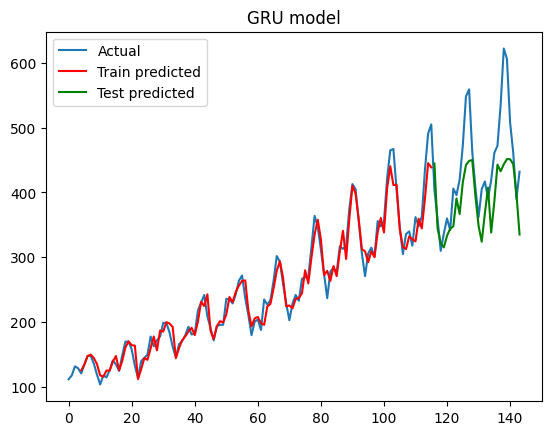

In [25]:
plot_model_results('GRU model', df['Passengers'], train_preds_gru, test_preds_gru)

In [26]:
net_rnn = RNN(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_rnn.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_rnn, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 1400 batches
[ 100,   13] train RMSE: 189.917, test RMSE: 385.522
[ 200,   13] train RMSE: 131.113, test RMSE: 315.982
[ 300,   13] train RMSE: 102.757, test RMSE: 277.303
[ 400,   13] train RMSE: 85.2413, test RMSE: 250.658
[ 500,   13] train RMSE: 71.557, test RMSE: 227.603
[ 600,   13] train RMSE: 59.6414, test RMSE: 205.236
[ 700,   13] train RMSE: 49.9829, test RMSE: 184.8
[ 800,   13] train RMSE: 42.256, test RMSE: 166.047
[ 900,   13] train RMSE: 36.4372, test RMSE: 148.827
[1000,   13] train RMSE: 32.194, test RMSE: 133.99
[1100,   13] train RMSE: 29.8588, test RMSE: 120.748
[1200,   13] train RMSE: 27.1592, test RMSE: 109.154
[1300,   13] train RMSE: 25.5004, test RMSE: 99.791
[1400,   13] train RMSE: 24.1952, test RMSE: 92.0425
[1500,   13] train RMSE: 24.1462, test RMSE: 88.1141
[1600,   13] train RMSE: 23.5804, test RMSE: 82.5548
[1700,   13] train RMSE: 22.8955, test RMSE: 81.0044
[1800,   13] train RMSE: 22.3875, test RMSE: 78.7525
[1900,   13] train RMSE: 23.

In [27]:
train_predict_loss_rnn, train_preds_rnn = predict(net_rnn, train_not_shuffle_loader, criterion)
test_predict_loss_rnn, test_preds_rnn = predict(net_rnn, test_loader, criterion)

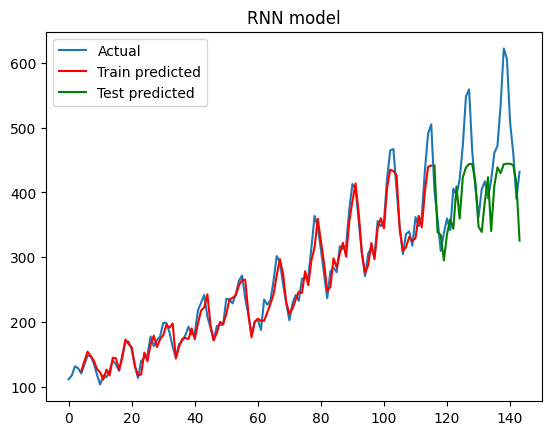

In [28]:
plot_model_results('RNN model', df['Passengers'], train_preds_rnn, test_preds_rnn)

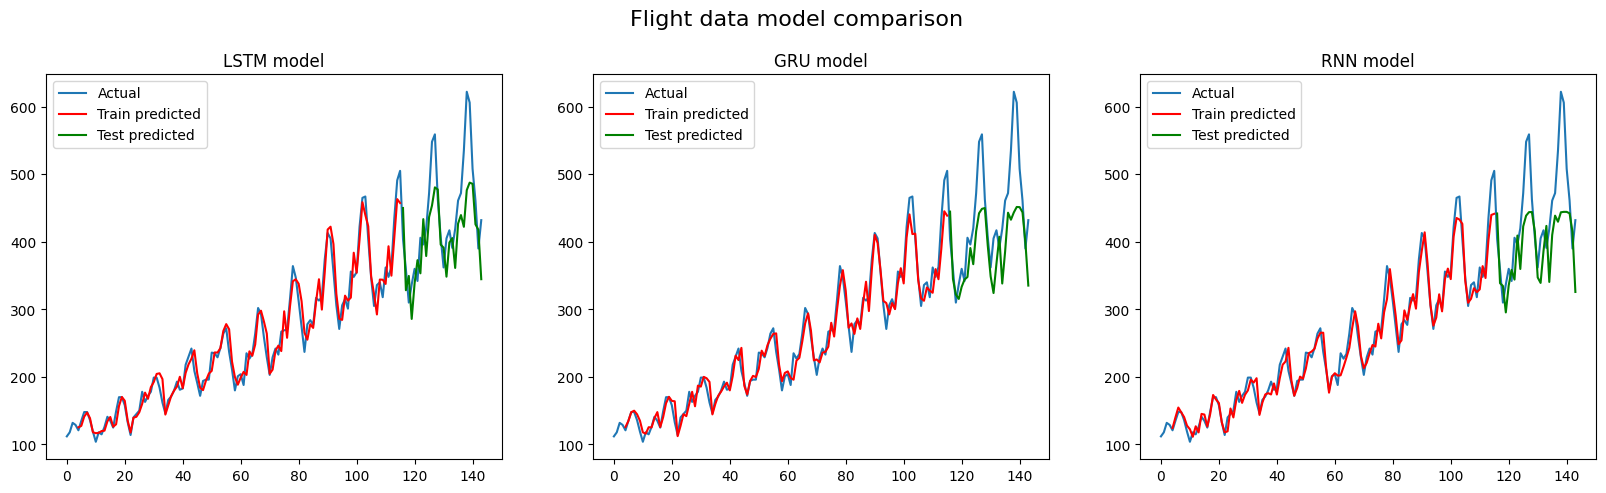

In [29]:
plot_all_results(
    "Flight data model comparison",
    lookback=4,
    actual=df['Passengers'].values,
    train_preds_lstm=train_preds_lstm,
    test_preds_lstm=test_preds_lstm,
    train_preds_gru=train_preds_gru,
    test_preds_gru=test_preds_gru,
    train_preds_rnn=train_preds_rnn,
    test_preds_rnn=test_preds_rnn
)

### Zad 2

In [58]:
import yfinance as yf
import seaborn as sns
from datetime import date
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler

In [59]:
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '1990-01-01'

##### AAPL

In [60]:
df = yf.download('AAPL', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [61]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.263078,183198400
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.264843,207995200
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.265727,221513600
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.266610,123312000
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.268375,101572800


In [62]:
def data_plot(df, title):
    df_plot = df.copy()

    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                           sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    fig.suptitle(title, fontsize=16, y=1.02)
    plt.show()

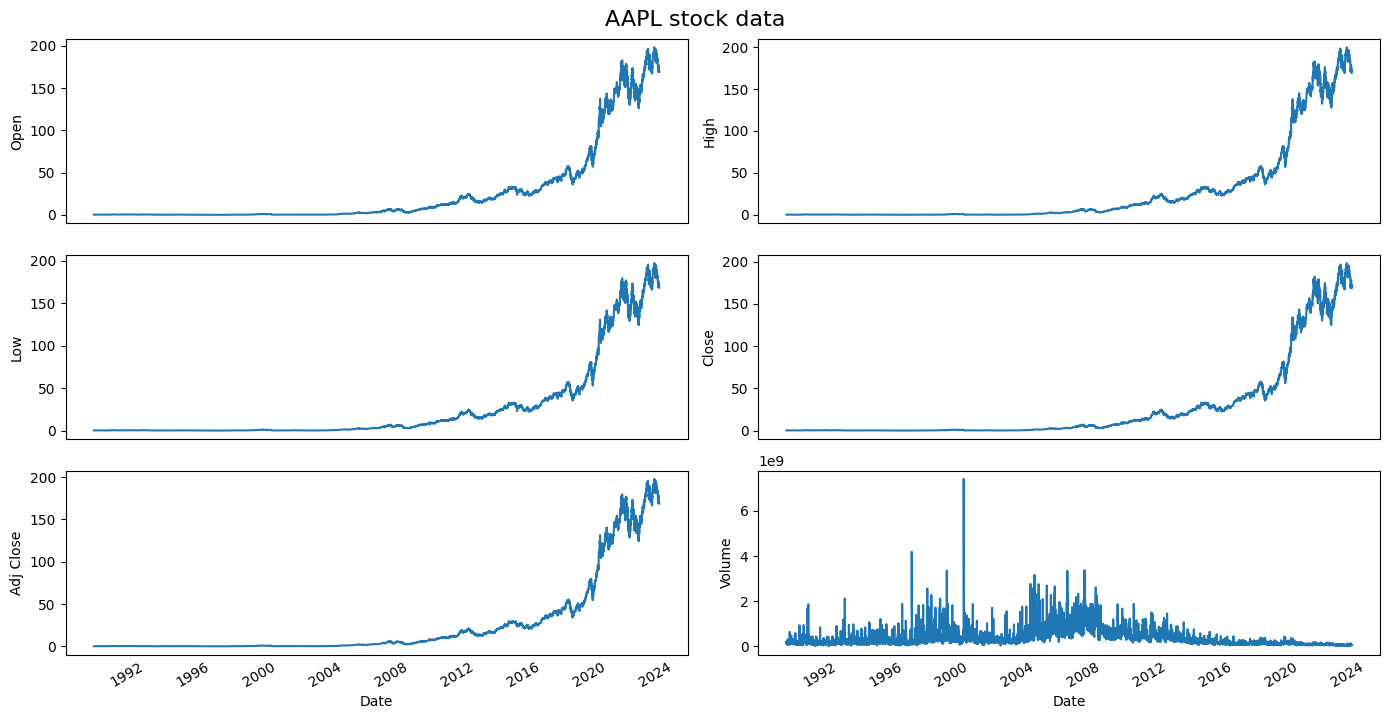

In [63]:
data_plot(df, 'AAPL stock data')

In [64]:
batch_size = 1024
lookback = 50

In [65]:
df['Open'].values.shape

(8628,)

In [66]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Open'].values.reshape(-1, 1))

In [67]:
ds = FunctionDataset(scaled_data, lookback=lookback, split_ratio=0.8)

train_shuffle_loader = data.DataLoader(ds.get_train_ds(), shuffle=True, batch_size=batch_size)
train_not_shuffle_loader = data.DataLoader(ds.get_train_ds(), shuffle=False, batch_size=batch_size)
test_loader = data.DataLoader(ds.get_test_ds(), shuffle=False, batch_size=batch_size)

[Dataset]: total samples 8628, sequence length 50, total sequences 8578, split ratio 0.8, train 6862, test 1716


In [68]:
len(train_shuffle_loader), len(test_loader)

(7, 2)

In [69]:
# get the first batch

X, y = next(iter(train_shuffle_loader))

X.shape, y.shape

(torch.Size([1024, 50, 1]), torch.Size([1024, 50, 1]))

In [70]:
net_lstm = LSTM(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_lstm.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_lstm, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 700 batches
[ 100,    6] train RMSE: 0.0053397, test RMSE: 0.0678569
[ 200,    6] train RMSE: 0.00247842, test RMSE: 0.0323555
[ 300,    6] train RMSE: 0.00126419, test RMSE: 0.0182709
[ 400,    6] train RMSE: 0.00106066, test RMSE: 0.0176472
[ 500,    6] train RMSE: 0.00234831, test RMSE: 0.0188384
[ 600,    6] train RMSE: 0.00105111, test RMSE: 0.0175298
[ 700,    6] train RMSE: 0.00102121, test RMSE: 0.0178254
[ 800,    6] train RMSE: 0.00104552, test RMSE: 0.0183204
[ 900,    6] train RMSE: 0.00104846, test RMSE: 0.0183416
[1000,    6] train RMSE: 0.00101372, test RMSE: 0.0188587
[1100,    6] train RMSE: 0.00161094, test RMSE: 0.0191406
[1200,    6] train RMSE: 0.00102051, test RMSE: 0.0199121
[1300,    6] train RMSE: 0.00106964, test RMSE: 0.0201227
[1400,    6] train RMSE: 0.00103618, test RMSE: 0.0213455
[1500,    6] train RMSE: 0.00110781, test RMSE: 0.0223488
[1600,    6] train RMSE: 0.00102763, test RMSE: 0.0224163
[1700,    6] train RMSE: 0.00101543, test RMSE: 0

In [71]:
train_predict_loss_lstm, train_preds_lstm = predict(net_lstm, train_not_shuffle_loader, criterion)
test_predict_loss_lstm, test_preds_lstm = predict(net_lstm, test_loader, criterion)

In [72]:
train_preds_lstm.shape,test_preds_lstm.shape, df['Open'].shape, 

((6862,), (1716,), (8628,))

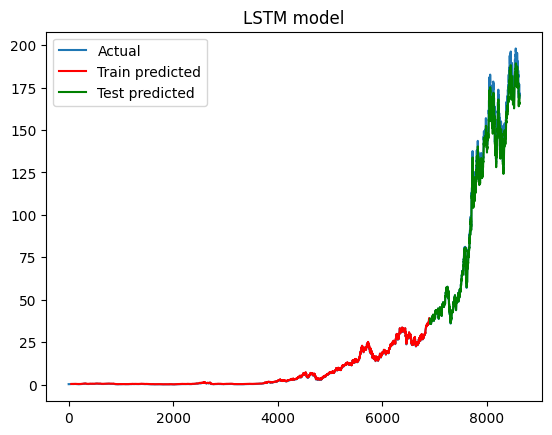

In [73]:
plot_model_results(
    title='LSTM model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_lstm.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_lstm.reshape(-1, 1)).flatten(),
    lookback=lookback
)

In [74]:
net_gru = GRU(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_gru.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_gru, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 700 batches
[ 100,    6] train RMSE: 0.00389961, test RMSE: 0.0522044
[ 200,    6] train RMSE: 0.00201702, test RMSE: 0.027891
[ 300,    6] train RMSE: 0.00121557, test RMSE: 0.0151541
[ 400,    6] train RMSE: 0.00103363, test RMSE: 0.0139664
[ 500,    6] train RMSE: 0.00102335, test RMSE: 0.0137838
[ 600,    6] train RMSE: 0.00101968, test RMSE: 0.0136618
[ 700,    6] train RMSE: 0.00102023, test RMSE: 0.0134219
[ 800,    6] train RMSE: 0.00101875, test RMSE: 0.0134796
[ 900,    6] train RMSE: 0.00108035, test RMSE: 0.0135599
[1000,    6] train RMSE: 0.00125502, test RMSE: 0.0131687
[1100,    6] train RMSE: 0.00172714, test RMSE: 0.014313
[1200,    6] train RMSE: 0.00129226, test RMSE: 0.0136572
[1300,    6] train RMSE: 0.0013836, test RMSE: 0.0134508
[1400,    6] train RMSE: 0.00100961, test RMSE: 0.0140434
[1500,    6] train RMSE: 0.00103748, test RMSE: 0.0146708
[1600,    6] train RMSE: 0.00106431, test RMSE: 0.0148496
[1700,    6] train RMSE: 0.00106734, test RMSE: 0.0

In [75]:
train_predict_loss_gru, train_preds_gru = predict(net_gru, train_not_shuffle_loader, criterion)
test_predict_loss_gru, test_preds_gru = predict(net_gru, test_loader, criterion)

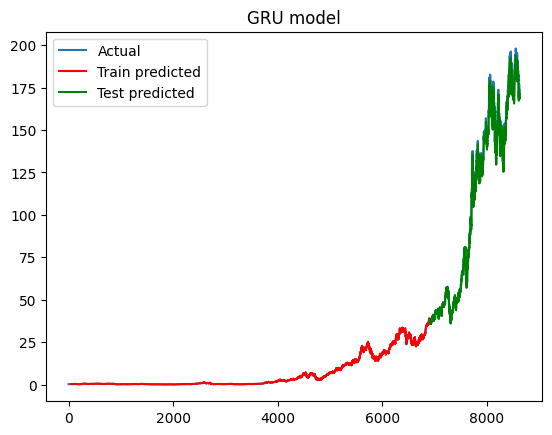

In [76]:
plot_model_results(
    title='GRU model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_gru.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_gru.reshape(-1, 1)).flatten(),
    lookback=lookback
)

In [77]:
net_rnn = RNN(input_size=1, hidden_size=50, num_layers=1, output_size=1).cuda()
optimizer = torch.optim.Adam(net_rnn.parameters(), lr=0.001)
criterion = nn.MSELoss()

learning_time = train(net_rnn, train_shuffle_loader, test_loader, criterion, optimizer, epochs)
print('Learning time: %.2f seconds' % learning_time)

Print every 700 batches
[ 100,    6] train RMSE: 0.00312402, test RMSE: 0.0433081
[ 200,    6] train RMSE: 0.00164052, test RMSE: 0.0244335
[ 300,    6] train RMSE: 0.00155541, test RMSE: 0.0169733
[ 400,    6] train RMSE: 0.00101703, test RMSE: 0.0168728
[ 500,    6] train RMSE: 0.00227806, test RMSE: 0.0186195
[ 600,    6] train RMSE: 0.00102096, test RMSE: 0.0179657
[ 700,    6] train RMSE: 0.00211466, test RMSE: 0.0202195
[ 800,    6] train RMSE: 0.00194201, test RMSE: 0.0208007
[ 900,    6] train RMSE: 0.00103992, test RMSE: 0.0204936
[1000,    6] train RMSE: 0.00107267, test RMSE: 0.0208783
[1100,    6] train RMSE: 0.00231024, test RMSE: 0.0226508
[1200,    6] train RMSE: 0.00101543, test RMSE: 0.0217642
[1300,    6] train RMSE: 0.00101531, test RMSE: 0.0231864
[1400,    6] train RMSE: 0.00101929, test RMSE: 0.0233263
[1500,    6] train RMSE: 0.00181902, test RMSE: 0.0240578
[1600,    6] train RMSE: 0.00104889, test RMSE: 0.0255224
[1700,    6] train RMSE: 0.00101861, test RMSE: 

In [78]:
train_predict_loss_rnn, train_preds_rnn = predict(net_rnn, train_not_shuffle_loader, criterion)
test_predict_loss_rnn, test_preds_rnn = predict(net_rnn, test_loader, criterion)

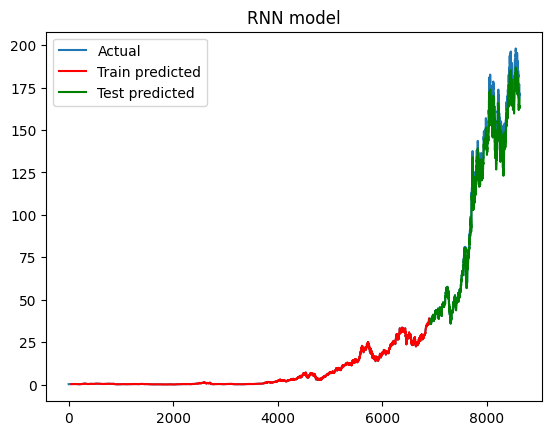

In [79]:
plot_model_results(
    title='RNN model', 
    actual=df['Open'].values, 
    train_preds=scaler.inverse_transform(train_preds_rnn.reshape(-1, 1)).flatten(), 
    test_preds=scaler.inverse_transform(test_preds_rnn.reshape(-1, 1)).flatten(),
    lookback=lookback
)

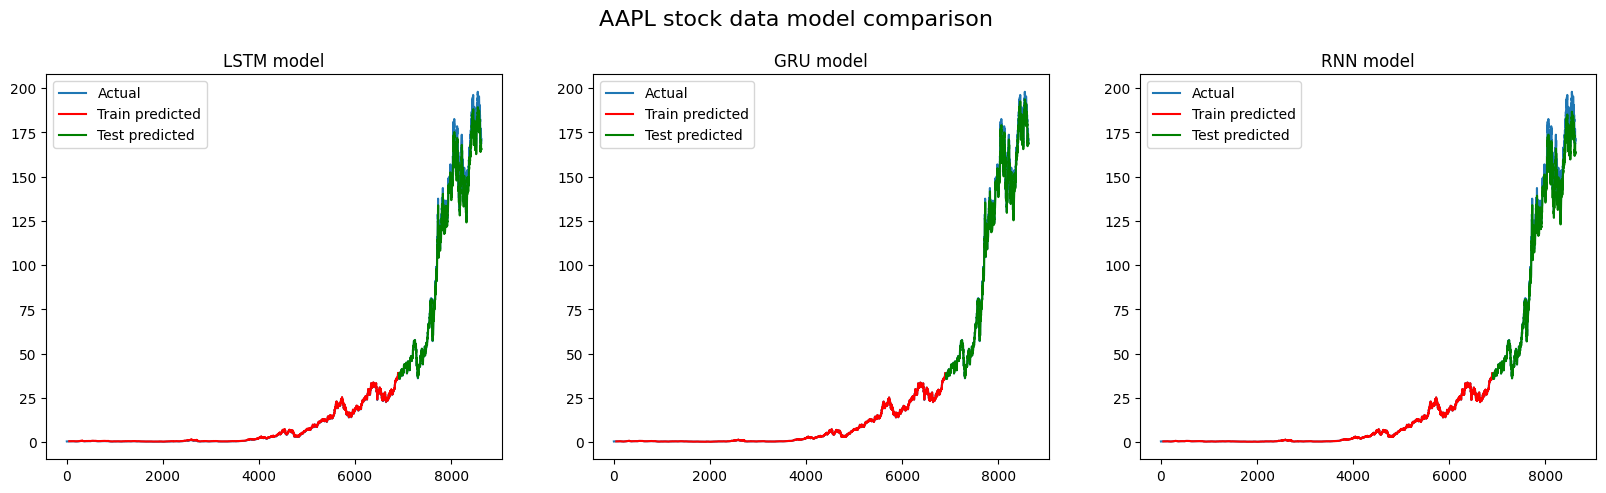

In [80]:
plot_all_results(
    title='AAPL stock data model comparison',
    lookback=lookback, 
    actual=df['Open'].values,
    train_preds_lstm=scaler.inverse_transform(train_preds_lstm.reshape(-1, 1)).flatten(), 
    test_preds_lstm=scaler.inverse_transform(test_preds_lstm.reshape(-1, 1)).flatten(),
    train_preds_gru=scaler.inverse_transform(train_preds_gru.reshape(-1, 1)).flatten(), 
    test_preds_gru=scaler.inverse_transform(test_preds_gru.reshape(-1, 1)).flatten(),
    train_preds_rnn=scaler.inverse_transform(train_preds_rnn.reshape(-1, 1)).flatten(), 
    test_preds_rnn=scaler.inverse_transform(test_preds_rnn.reshape(-1, 1)).flatten()
)